In [50]:
import pandas as pd
import datetime
import numpy as np
import random
import matplotlib.pyplot as plt
import datetime

# Set display options
pd.set_option('display.max_rows', 1000)  # Set the maximum number of displayed rows to 100
pd.set_option('display.max_columns', 1000)  # Set the maximum number of displayed columns to 50

seed_value = 100  # you can set a seed value of your choice

np.random.seed(seed_value)  # seed for NumPy
random.seed(seed_value)  # seed for Python random module

# # plt.rcParams["figure.figsize"] = [8, 6]  # set the figure size
# plt.rcParams["figure.dpi"] = 250  # set the resolution in dpi

In [61]:
import pandas as pd
import datetime
from pathlib import Path

# Your data directory
data_path = Path('/home/sayem/Desktop/Lobster/data')


def process_LOB_data(MSGFileName, LOBFileName):
    # Extracting the date from the filename
    ticker, rem = Path(MSGFileName).name.split('_', 1)
    date = rem.split('_', 1)[0]

    # Convert date into datetime format
    date = datetime.datetime.strptime(date, '%Y-%m-%d')

    # Message file
    DSMSG = pd.read_csv(MSGFileName, header=None)
    DSMSG.columns = ["Time", "Type", "OrderID", "Size", "Price", "Direction"]

    # Data file
    DSLOB = pd.read_csv(LOBFileName, header=None)

    # Assuming you have 20 columns in DSLOB
    DSLOB.columns = ["AskPrice1", "AskSize1", "BidPrice1", "BidSize1",
                    "AskPrice2", "AskSize2", "BidPrice2", "BidSize2",
                    "AskPrice3", "AskSize3", "BidPrice3", "BidSize3",
                    "AskPrice4", "AskSize4", "BidPrice4", "BidSize4",
                    "AskPrice5", "AskSize5", "BidPrice5", "BidSize5"]

    # Convert 'Time' to datetime format and calculate seconds from midnight
    DSMSG['Time'] = pd.to_timedelta(DSMSG['Time'], unit='s')

    # Add the actual date to 'Time'
    DSMSG['Time'] = date + DSMSG['Time']

    # Combine DSMSG and DSLOB
    TimeVariable = DSMSG["Time"]
    LOB3Variables = DSLOB[["AskPrice1", "AskSize1", "BidPrice1", "BidSize1",
                        "AskPrice2", "AskSize2", "BidPrice2", "BidSize2",
                        "AskPrice3", "AskSize3", "BidPrice3", "BidSize3"]]

    ## LOB level 3 data
    combined_orderbook_data = pd.concat([TimeVariable, LOB3Variables], axis=1)

    return combined_orderbook_data


# Process data for each stock
aapl_msg_file = data_path / 'AAPL_2012-06-21_34200000_57600000_message_5.csv'
aapl_lob_file = data_path / 'AAPL_2012-06-21_34200000_57600000_orderbook_5.csv'
aapl_data = process_LOB_data(aapl_msg_file, aapl_lob_file)

amzn_msg_file = data_path / 'AMZN_2012-06-21_34200000_57600000_message_5.csv'
amzn_lob_file = data_path / 'AMZN_2012-06-21_34200000_57600000_orderbook_5.csv'
amzn_data = process_LOB_data(amzn_msg_file, amzn_lob_file)


# Process data for each stock
intc_msg_file = data_path / 'INTC_2012-06-21_34200000_57600000_message_5.csv'
intc_lob_file = data_path / 'INTC_2012-06-21_34200000_57600000_orderbook_5.csv'
intc_data = process_LOB_data(intc_msg_file, intc_lob_file)

In [62]:
aapl_data.head()

,Time,AskPrice1,AskSize1,BidPrice1,BidSize1,AskPrice2,AskSize2,BidPrice2,BidSize2,AskPrice3,AskSize3,BidPrice3,BidSize3
0,2012-06-21 09:30:00.004241176,5859400,200,5853300,18,5859800,200,5853000,150,5861000,200,5851000,5
1,2012-06-21 09:30:00.004260640,5859400,200,5853300,18,5859800,200,5853200,18,5861000,200,5853000,150
2,2012-06-21 09:30:00.004447484,5859400,200,5853300,18,5859800,200,5853200,18,5861000,200,5853100,18
3,2012-06-21 09:30:00.025551909,5859100,18,5853300,18,5859400,200,5853200,18,5859800,200,5853100,18
4,2012-06-21 09:30:00.025579546,5859100,18,5853300,18,5859200,18,5853200,18,5859400,200,5853100,18


In [63]:
def calculate_average_return(df):
    price_cols = [(f'AskPrice{i+1}', f'BidPrice{i+1}', f'AskSize{i+1}', f'BidSize{i+1}') for i in range(3)]  # modify here if you have more levels

    # Calculate the volume-weighted mid-price and returns for each level
    for i, (ask_price_col, bid_price_col, ask_size_col, bid_size_col) in enumerate(price_cols, 1):
        df[f'VWMidPrice{i}'] = (df[ask_price_col] * df[ask_size_col] + df[bid_price_col] * df[bid_size_col]) / (df[ask_size_col] + df[bid_size_col])
        df[f'Return{i}'] = df[f'VWMidPrice{i}'].pct_change()

    # Calculate average return
    df['AvgReturn'] = df[[f'Return{i}' for i in range(1, len(price_cols) + 1)]].mean(axis=1)
    
    # Smooth returns using a moving average
    window_size = 10 ** 5  # You can adjust this value to your needs
    df['SmoothAvgReturn'] = df['AvgReturn'].rolling(window_size).mean()
    
    return df

In [70]:
avg_return_aapl = calculate_average_return(aapl_data)
avg_return_amzn = calculate_average_return(amzn_data)
avg_return_intc = calculate_average_return(intc_data)

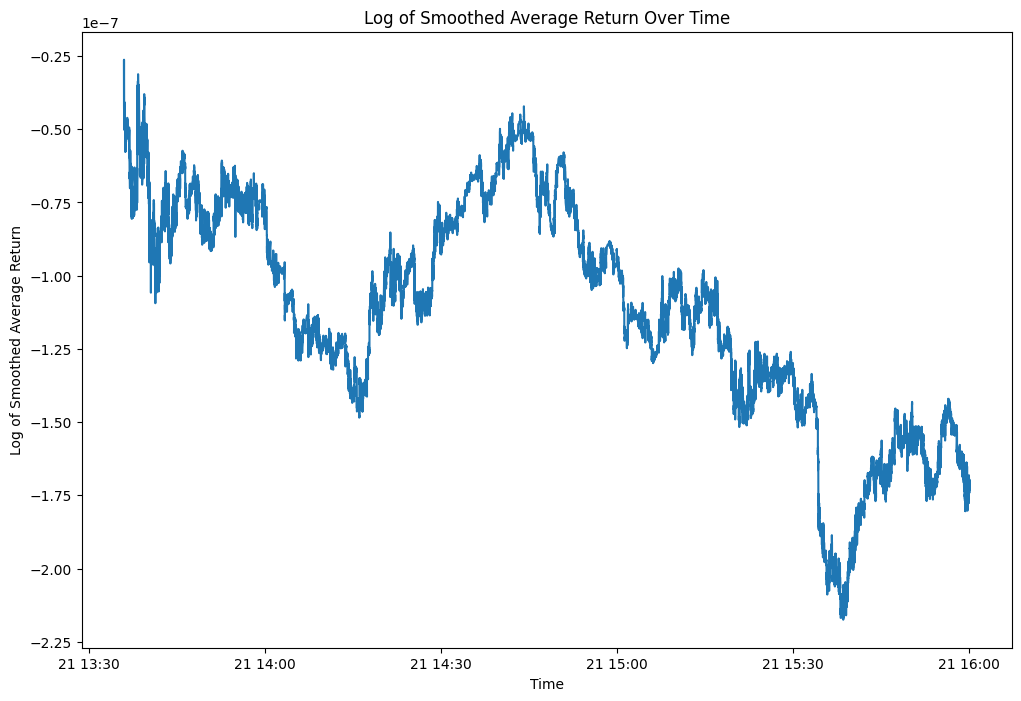

In [71]:
plt.figure(figsize=(12,8))
plt.plot(avg_return['Time'], avg_return['SmoothAvgReturn'])
plt.xlabel('Time')
plt.ylabel('Log of Smoothed Average Return')
plt.title('Log of Smoothed Average Return Over Time')
plt.show()

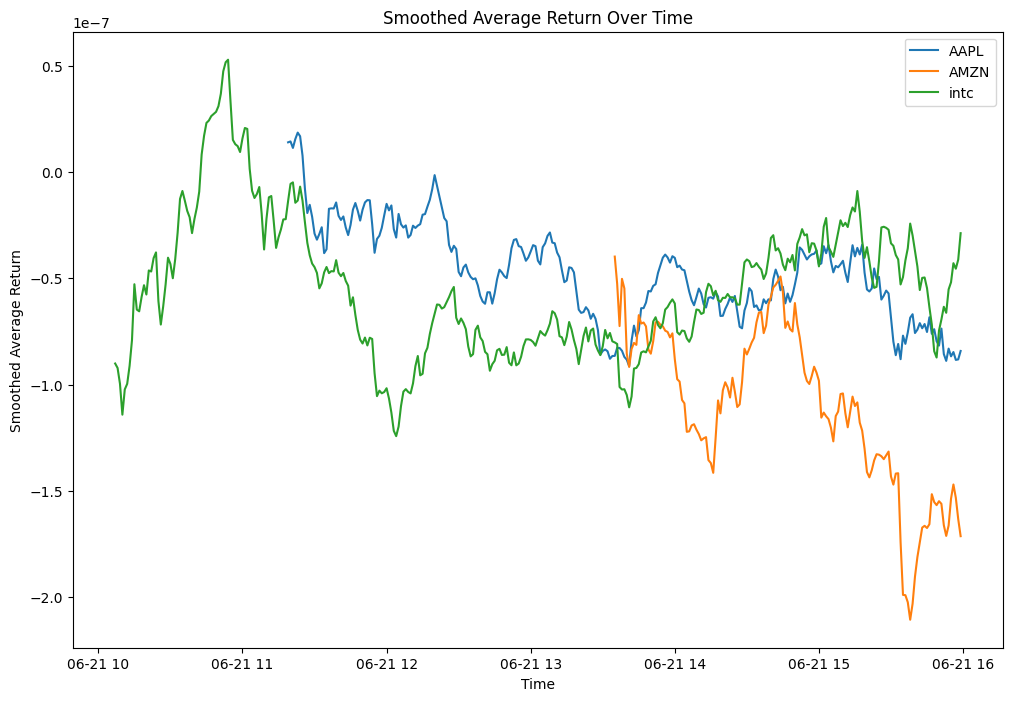

In [76]:
import matplotlib.pyplot as plt

# Resampling data to 1-minute intervals
resampled_avg_return_aapl = avg_return_aapl.resample('1T', on='Time').mean()
resampled_avg_return_amzn = avg_return_amzn.resample('1T', on='Time').mean()
resampled_avg_return_intc = avg_return_intc.resample('1T', on='Time').mean()

plt.figure(figsize=(12,8))
plt.plot(resampled_avg_return_aapl.index, resampled_avg_return_aapl['SmoothAvgReturn'], label='AAPL')
plt.plot(resampled_avg_return_amzn.index, resampled_avg_return_amzn['SmoothAvgReturn'], label='AMZN')
plt.plot(resampled_avg_return_intc.index, resampled_avg_return_intc['SmoothAvgReturn'], label='intc')

plt.xlabel('Time')
plt.ylabel('Smoothed Average Return')
plt.title('Smoothed Average Return Over Time')
plt.legend()
plt.show()
